# Xgboost workshop (python version)
by Qi XU & Maxime KINET 

# Competition: B2C - Predict conversion rates on breakdown services

For more detail see https://datascience-challenge.engie.com/#/challenge/28733

# Import Xgboost and other packages 

In [1]:
get_ipython().magic(u'matplotlib inline')
import xgboost as xgb
import pandas as pd
import numpy as np
from scipy import sparse
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold

# Now we need to load the train and test data sets

In [2]:
fold_ad = "C:/Users/IA2069/Documents/MK2016/"
train=pd.read_csv(fold_ad+"train.CSV") # change to your local file address  
train.head()
goal = train["souscrit"]

In [3]:
test =pd.read_csv(fold_ad+"test.CSV") # change to your local file address
test.head(2)

,DT_DEBT_ASSR,TYPE_OFFRE_GAZ,Tarif_ach,CODE_TYPE_COMPTAGE,PUIS_SOUS,PAYEUR_DIVERG,OFFRE,CAP_EC,CODE_STATUT_LOGEMENT,CODE_TYPE_HABITAT,...,nb_contact_entrant,LB_PROF_PAYR,ass_fact,CRC,PARTENAIRES,MAILING,PAP,DARTY,TV,produit
0,2015-11-03,OM,T2,SIMP,6.0,0,DUAL,0,PRV,H1,...,6,SANS INCIDENT DE PAIEMENT,0,4.0,0.0,0.0,0.0,0.0,0.0,DEGEX+
1,2015-08-27,OM,T1,SIMP,6.0,0,DUAL,0,PRV,H2,...,0,SANS INCIDENT DE PAIEMENT,0,0.0,2.0,0.0,0.0,0.0,0.0,DEPEX+


# PRE PROCESSING 

In [4]:
#Train test blind
test["souscrit"] = np.nan
db = pd.concat([train,test],axis=0)
db.shape

(254945, 42)

In [5]:
# fill empty values
# replace by mean
mean_replace_list = ["AGE_TR_PRED_FMT","REVENU_IRIS","CAR_CHAR","CODE_INSEE","CRC","PARTENAIRES","MAILING","PAP","DARTY","TV"]
db[mean_replace_list]=db[mean_replace_list].fillna(db[mean_replace_list].mean())

# replace by single value
db["PUIS_SOUS"]=db["PUIS_SOUS"].fillna(0)
db["TYPIRIS_N1"]=db["TYPIRIS_N1"].fillna("z")

In [6]:
# variables type lists
num_var_name = [u'AGE_TR_PRED_FMT', u'CAP_EC', u'CAR_CHAR', u'CEL_FMT', u'CODE_INSEE',u'CRC',u'DARTY',u'FACT_LIGN_FMT', 
               u'MAILING', u'MA_RLV_FMT',u'NB_COHABITANT',u'PAP', u'PARTENAIRES', u'PAYEUR_DIVERG',u'PREA', u'PUIS_SOUS', u'REVENU_IRIS',
               u'TV', u'ass_fact',u'nb_cont_COUR_ENT', u'nb_cont_MAIL_ENT', u'nb_cont_RECLAMATION',
               u'nb_cont_RECLAMATION_6M', u'nb_cont_TEL_ENT', u'nb_contact_entrant']
date_var_name  = [u'DATE_ANC_CLI',u'DATE_EMMENAG',u'DT_DEBT_ASSR']
factor_var_name =  [u'CODE_STATUT_LOGEMENT', u'CODE_STATUT_OCCUP', u'CODE_TYPE_COMPTAGE',u'CODE_TYPE_HABITAT',u'DRP', u'FREQ_FACT', u'LB_PROF_PAYR',
                   u'OFFRE',  u'SEG_VALEUR_N2_A',u'TYPE_OFFRE_GAZ', u'TYPIRIS_N1', u'Tarif_ach', u'produit']

In [7]:
# Transform of timestamps
def time_attr_frame(timestamp):
    month    = timestamp.month
    week_day = timestamp.weekday()
    yday    = timestamp.timetuple().tm_yday # day of year (leak feature)
    return pd.Series({"month":month,"week_day":week_day,"yday":yday})

db["DT_DEBT_ASSR"] = pd.to_datetime(db["DT_DEBT_ASSR"], format='%Y-%m-%d')
db[["DT_DEBT_ASSR_yday","DT_DEBT_ASSR_month","DT_DEBT_ASSR_week_day"]]=db[["DT_DEBT_ASSR"]].apply(lambda x:time_attr_frame(x[0]),axis=1)


In [8]:
# Tranform to years
db["DATE_ANC_CLI_year"]=db[["DATE_ANC_CLI"]].apply(lambda x: int(x[0][0:4]),axis=1)
db["DATE_EMMENAG_year"]=db[["DATE_EMMENAG"]].apply(lambda x: int(x[0][0:4]),axis=1)

In [9]:
# to save sometime all the factor data will not be used in this notebook
db_final = db[num_var_name + ["DT_DEBT_ASSR_yday","DT_DEBT_ASSR_month","DT_DEBT_ASSR_week_day","DATE_ANC_CLI_year","DATE_EMMENAG_year"]]

In [10]:
# seperate train & test
train = db_final.iloc[0:127472,:]
test  = db_final.iloc[127472:254945,:]

# Now we are ready for our Xgboost models

# Tunning

In [11]:
# define parameters we are going to use
params = {                    "objective": "binary:logistic",
                              "eval_metric": "auc",
                              "eta": 0.5,
                              "max_depth": 4,
                              "min_child_weight": 10,
                              "subsample": 0.9,
                              "colsample_bytree": 0.9,
                              "nthread":3
                              }
num_trees = 5 # to save time you can test with more num_trees to get a better performance by yourself                      

In [12]:
# training by build in cv function (random split)
dtrain    = xgb.DMatrix(train,goal)
xgb_cv = xgb.cv(params,dtrain,num_trees,nfold=3)

In [13]:
# to see cv score
xgb_cv

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.679603,0.014124,0.681706,0.007878
1,0.699760,0.017512,0.701800,0.014970
2,0.714073,0.005910,0.718768,0.005459
3,0.715800,0.003370,0.719384,0.006081
4,0.723803,0.002257,0.728477,0.003604


In [14]:
# training by watchlist (can use custom cv split strategies)
data_len = 127472
skf = KFold(data_len,n_folds=3,shuffle= True)
for train_index,test_index in skf:
    train_train = train.iloc[train_index,:]
    train_test  = train.iloc[test_index,:]
    goal_train  = goal.iloc[train_index]
    goal_test   = goal.iloc[test_index]
    
    dtrain_cv    = xgb.DMatrix(train_train,goal_train)
    dtest_cv     = xgb.DMatrix(train_test, goal_test)
    watchlist = [(dtest_cv,"eval"),(dtrain_cv,"train")]
    xgb_cv = xgb.train(params,dtrain_cv,num_trees,watchlist)

[0]	eval-auc:0.670408	train-auc:0.672514
[1]	eval-auc:0.685273	train-auc:0.689972
[2]	eval-auc:0.693844	train-auc:0.698377
[3]	eval-auc:0.697499	train-auc:0.699106
[4]	eval-auc:0.700995	train-auc:0.703742
[0]	eval-auc:0.690358	train-auc:0.690839
[1]	eval-auc:0.71466	train-auc:0.717907
[2]	eval-auc:0.71314	train-auc:0.715997
[3]	eval-auc:0.723104	train-auc:0.72469
[4]	eval-auc:0.723587	train-auc:0.730677
[0]	eval-auc:0.667416	train-auc:0.673451
[1]	eval-auc:0.686865	train-auc:0.695726
[2]	eval-auc:0.690206	train-auc:0.698749
[3]	eval-auc:0.689627	train-auc:0.69853
[4]	eval-auc:0.705706	train-auc:0.714329


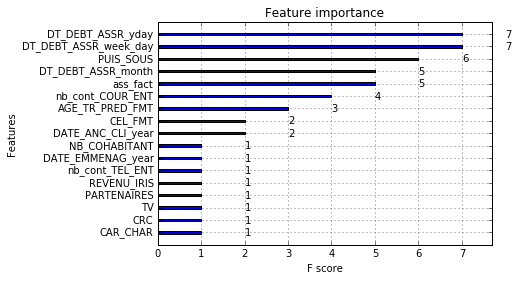

In [15]:
# feature importance to see which features are more importants than others
xgb.plot_importance(xgb_cv)

# Train and prediction 

In [16]:
xgb_final = xgb.train(params,dtrain)
dtest    = xgb.DMatrix(test)
pred = xgb_final.predict(dtest)

In [17]:
submission = pd.read_csv(fold_ad+"sample_submission.CSV")
submission["predictions"]=pred
submission.to_csv(fold_ad + "myfirst_submission.CSV",index=False)

# Congratulations you have completed your first xgboost workshop!